# Assignment 3: Image Classification

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
random.seed(1)

## Question 1. Data (20%)

Download the data from the course website. 

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [23]:
import glob
def read_dataset(path):
  data = []
  for file in glob.glob(path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    data.append(filename)
  return data


In [24]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files
train_path = "/content/gdrive/My Drive/shoes_data_set/train/*.jpg"
test_w_path = "/content/gdrive/My Drive/shoes_data_set/test_w/*.jpg"
test_m_path = "/content/gdrive/My Drive/shoes_data_set/test_m/*.jpg"
train_data = read_dataset(train_path)
test_w_data = read_dataset(test_w_path)
test_m_data =  read_dataset(test_m_path)

In [25]:
def convert_to_df(files_names):
  df=pd.DataFrame(files_names)
  df=df.sort_values(by=0)
  df2=df.copy()
  df[0]= df[0].str.split("_", n = 1, expand = True)
  df.columns=['id']
  df['img_path']=df2
  
  df=df.reset_index(inplace=False).drop('index',axis=1)
  return df

In [26]:
df_train = convert_to_df(train_data)
df_test_m = convert_to_df(test_m_data)
df_test_w = convert_to_df(test_w_data)

df_train.head(10)

,id,img_path
0,u001,u001_1_left_w.jpg
1,u001,u001_1_right_w.jpg
2,u001,u001_2_left_w.jpg
3,u001,u001_2_right_w.jpg
4,u001,u001_3_left_w.jpg
5,u001,u001_3_right_w.jpg
6,u003,u003_1_left_m.jpg
7,u003,u003_1_right_m.jpg
8,u003,u003_2_left_m.jpg
9,u003,u003_2_right_m.jpg


In [27]:
def split_train_test(df_train, test_ratio):
 user=pd.DataFrame(list(set(df_train['id'])))
 train_users,val_users=train_test_split(user,test_size=test_ratio)
 train_users=list(train_users[0])
 val_users=list(val_users[0])
 train=df_train[df_train['id'].isin(train_users)]
 train=train.reset_index(inplace=False).drop('index',axis=1)
 val=df_train[df_train['id'].isin(val_users)]
 val=val.reset_index(inplace=False).drop('index',axis=1)
 return train,val

In [28]:
df_train , df_val= split_train_test(df_train, 0.2)

In [29]:
def preapare_data(df,path_dir):
  data=list()
  users=list(set(df['id']))
  users.sort()
  print(users)
  for i,user in enumerate(users):
    # Extract only a specific user data in a dataframe format
    user_data=df[df['id'] == user]
    # Organize the user dataframe
    user_data=user_data.reset_index(inplace=False).drop('index',axis=1)
    user_shoes = list()
    # create numpy array for all user shoes
    for shoe_idx in range(0,6,2):
      # Read the left shoe of the user
      image_left=plt.imread(path_dir+user_data.loc[shoe_idx,"img_path"])
      # Remove the alpha dimension
      image_left=image_left[:, :, :3]
      # Normalize the pixels values between [-0.5,0.5]
      image_left =image_left/255 - 0.5
      # Read the right shoe of the user
      image_right=plt.imread(path_dir+user_data.loc[shoe_idx+1,"img_path"])
      # Remove the alpha dimension
      image_right=image_right[:, :, :3]
      # Normalize the pixels values between [-0.5,0.5]
      image_right=image_right/255 - 0.5
      # Add the new images to the user shoes array
      user_shoes.append([image_left, image_right])

    user_shoes=np.array(user_shoes)
    data.append(user_shoes)
  data=np.array(data)
  return data


In [30]:
train_dir = train_path[:-5]
test_w_dir = test_w_path[:-5]
test_m_dir = test_m_path[:-5]
train_data = preapare_data(df_train,train_dir)
valid_data = preapare_data(df_val, train_dir)
test_w_data = preapare_data(df_test_w,test_w_dir)
test_m_data = preapare_data(df_test_m,test_m_dir)

['u001', 'u004', 'u006', 'u009', 'u010', 'u013', 'u015', 'u016', 'u017', 'u018', 'u019', 'u020', 'u021', 'u023', 'u025', 'u026', 'u027', 'u028', 'u030', 'u032', 'u034', 'u035', 'u037', 'u038', 'u039', 'u042', 'u046', 'u048', 'u049', 'u050', 'u051', 'u053', 'u054', 'u055', 'u058', 'u059', 'u063', 'u064', 'u065', 'u066', 'u069', 'u072', 'u073', 'u074', 'u075', 'u076', 'u078', 'u081', 'u082', 'u084', 'u085', 'u088', 'u090', 'u091', 'u092', 'u093', 'u094', 'u096', 'u097', 'u098', 'u099', 'u100', 'u101', 'u102', 'u103', 'u104', 'u105', 'u106', 'u107', 'u108', 'u109', 'u111', 'u112', 'u116', 'u117', 'u118', 'u119', 'u121', 'u122', 'u123', 'u125', 'u126', 'u127', 'u128', 'u129', 'u130', 'u131', 'u132', 'u133']
['u003', 'u007', 'u012', 'u022', 'u029', 'u031', 'u040', 'u041', 'u043', 'u044', 'u056', 'u061', 'u062', 'u067', 'u070', 'u077', 'u083', 'u086', 'u087', 'u089', 'u113', 'u114', 'u124']
['u011', 'u014', 'u033', 'u036', 'u045', 'u060', 'u079', 'u095', 'u110', 'u120']
['u002', 'u005', 'u00

In [31]:
print(f'Train Dataset shape - {train_data.shape}')
print(f'Validation Dataset shape - {valid_data.shape}')
print(f'Test Woman Dataset shape - {test_w_data.shape}')
print(f'Test Man Dataset shape - {test_m_data.shape}')

Train Dataset shape - (89, 3, 2, 224, 224, 3)
Validation Dataset shape - (23, 3, 2, 224, 224, 3)
Test Woman Dataset shape - (10, 3, 2, 224, 224, 3)
Test Man Dataset shape - (10, 3, 2, 224, 224, 3)


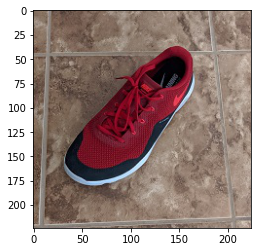

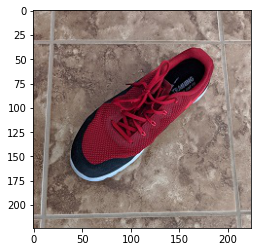

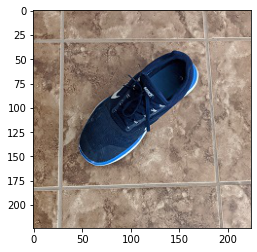

In [32]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:] + 0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:] + 0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:] + 0.5) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


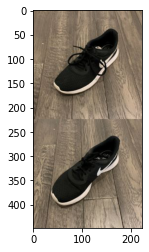

In [33]:
# Your code goes here
def generate_same_pair(dataset):
  new_datset = np.zeros((dataset.shape[0]*dataset.shape[1], 448, 224, 3))
  for user_idx in range(dataset.shape[0]):
    for shoes_idx in range(dataset.shape[1]):
      left_shoe = dataset[user_idx,shoes_idx,0,...]
      right_shoe = dataset[user_idx,shoes_idx,1,...]
      new_datset[dataset.shape[1]*user_idx + shoes_idx] = np.vstack((left_shoe, right_shoe))
  return np.array(new_datset)

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


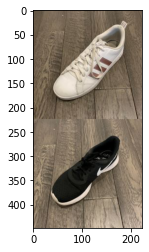

In [34]:
# Your code goes here
def generate_different_pair(dataset):
  new_datset = np.zeros((dataset.shape[0]*dataset.shape[1], 448, 224, 3))
  all_combinations = [(j,k) for j in range(dataset.shape[1]) for k in range(dataset.shape[1]) if j!=k]
  for user_idx in range(dataset.shape[0]):
    samp_shoe = random.sample(all_combinations,dataset.shape[1])
    for shoes_idx in range(dataset.shape[1]):
      left_shoe = dataset[user_idx,samp_shoe[shoes_idx][0],0,...]
      right_shoe = dataset[user_idx,samp_shoe[shoes_idx][1],1,...]
      new_datset[dataset.shape[1]*user_idx + shoes_idx] = np.vstack((left_shoe, right_shoe))
  return np.array(new_datset)
# Run this code, include the result with your PDF submission

print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]+0.5) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Write your explanation here:**
We have to make sure that the algorithm will decide if the 2 shoes are from the same pair or not based on the shoe and not based on other elements.
if the shoes are from different users, the background, the image quality, the angle, brightness, etc, will be different and the algorithm may decide according to these environment features and not based on the shoe features. Thus, by taking pairs from the same users, the environment features are similar and hence we enhance the algorithm capabilities such that it focuses more on the shoe features instead of irrelevant features.

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem? 

**Write your explanation here:**

If the data is not balanced, for example, 99% of the images are of shoes that are not from the same pair, and 1% of the images are shoes that are from the same pair, the model will probably learn to always predict that the shoes are not from the same pairs and will have a 99% of accuracy over the training set (and even over the validation set if it is imbalanced too). Obviously, this model is poor because it always predicts the same output without considering the input

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [35]:
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        # TODO: complete this method
        kernel_size = 5
        self.convs = []
        self.pools = []
        in_channels = 3
        out_channels = n
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,
                               padding=int((kernel_size-1)/2))
        self.conv2 = nn.Conv2d(in_channels=out_channels,
                               out_channels=out_channels*2,
                               kernel_size=kernel_size,
                               padding=int((kernel_size-1)/2))
        self.conv3 = nn.Conv2d(in_channels=out_channels*2,
                               out_channels=out_channels*4,
                               kernel_size=kernel_size,
                               padding=int((kernel_size-1)/2))
        self.conv4 = nn.Conv2d(in_channels=out_channels*4,
                               out_channels=out_channels*8,
                               kernel_size=kernel_size,
                               padding=int((kernel_size-1)/2))
        self.fc1 = nn.Linear(8*n*28*14,100)
        self.output = nn.Linear(100,2)
        self.activation = nn.ReLU()
  
    def forward(self, x):
      x = self.conv1(x)
      x = self.activation(x)
      x = nn.MaxPool2d(kernel_size=2)(x)
      x = self.conv2(x)
      x = self.activation(x)
      x = nn.MaxPool2d(kernel_size=2)(x)
      x = self.conv3(x)
      x = self.activation(x)
      x = nn.MaxPool2d(kernel_size=2)(x)
      x = self.conv4(x)
      x = self.activation(x)
      x = nn.MaxPool2d(kernel_size=2)(x)
      x = nn.Flatten()(x)
      x = self.activation(self.fc1(x))
      output = self.output(x)
      return output

### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [36]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        kernel_size = 5
        self.convs = []
        self.pools = []
        in_channels = 6
        out_channels = n
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels, 
                               kernel_size=kernel_size,
                               padding=int((kernel_size-1)/2))
        self.conv2 = nn.Conv2d(in_channels=out_channels,
                               out_channels=out_channels*2,
                               kernel_size=kernel_size,
                               padding=int((kernel_size-1)/2))
        self.conv3 = nn.Conv2d(in_channels=out_channels*2,
                               out_channels=out_channels*4,
                               kernel_size=kernel_size,
                               padding=int((kernel_size-1)/2))
        self.conv4 = nn.Conv2d(in_channels=out_channels*4,
                               out_channels=out_channels*8,
                               kernel_size=kernel_size,
                               padding=int((kernel_size-1)/2))
        self.fc1 = nn.Linear(8*n*14*14,100)
        self.output = nn.Linear(100,2)
        self.activation = nn.ReLU()

    def forward(self,x):
      x = torch.cat((x[...,0:224], x[...,224:]), dim=1)
      x = self.conv1(x)
      x = self.activation(x)
      x = nn.MaxPool2d(kernel_size=2)(x)
      x = self.conv2(x)
      x = self.activation(x)
      x = nn.MaxPool2d(kernel_size=2)(x)
      x = self.conv3(x)
      x = self.activation(x)
      x = nn.MaxPool2d(kernel_size=2)(x)
      x = self.conv4(x)
      x = self.activation(x)
      x = nn.MaxPool2d(kernel_size=2)(x)
      x = nn.Flatten()(x)
      x = self.activation(self.fc1(x))
      output = self.output(x)
      return output
      

## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**
When using a Convolutional Neural Network, the goal of the kernels at each layer is to extract spatial featurs from the previous layer output throughout all channels. Thus, when combining the images along the channel axis, we facilitate the model to compare pixels at the same postion for both images. Thus, we think that the CNNChannel model will perform the best. 
In addition, when concatenating an image as in the CNN model, it is not so clear what is boundaries for each image.

## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

To explain this we will use an example.
Assume 

**Write your explanation here:**
When we measure the model preformamce in terms of false positive and false negative rates we actually track the preformance with more information than just tracking the model accuracy since when we track over the accuracy we may think that the model preformance are good while its true negative or true positive rates are poor. For example, assuming a balanced dataset, if the model can recognize 100% of the positive examples but only 40% of the negative examples we will observe average accuracy of 70%. It may seem that most of the time the model is able to predict the right class but actually the model succeed to learn only the positive example. 

In [37]:
def get_accuracy(model, data, batch_size=50, device='cpu'):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      #  [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # shape [n * 3, 448, 224, 3]
    
    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3).to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3).to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [38]:
# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
import pickle
from sklearn.utils import shuffle
def train(model,train_data=train_data, 
          validation_data=valid_data, 
          batch_size=100,
          learning_rate=0.001, 
          weight_decay=0,
          epochs=5, 
          max_iters=1000,
          checkpoint_path='/content/gdrive/My Drive/shoes_data_set/checkpoints/ckpt-acc-{}.pk',
          best_val_acc=0,
          best_val_acc_pos_neg_dif=100,
          to_save=False,
          eval_freq = 3):
  # Verify that the batch size is valid
  assert batch_size % 2 == 0
  # Define Loss function as criterion
  criterion = nn.CrossEntropyLoss()
  # Define optimizer for the training procedure
  optimizer = optim.Adam(model.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay)
  
  # Generate Positive and Negative samples
  data_pos = generate_same_pair(train_data)
  data_neg = generate_different_pair(train_data)
  # Tag the data with matching labels
  labels_pos=torch.ones(int(batch_size / 2), dtype=torch.long)
  labels_neg=torch.zeros(int(batch_size / 2), dtype=torch.long)
  # Merge the labels
  labels=torch.cat((labels_pos, labels_neg), 0).to(device)

  epochs_l,losses ,acc_train_pos,acc_train_neg,acc_val_pos,acc_val_neg = [], [] , [] , [] ,[],[]
  half_batch = int(batch_size/2)
  for epoch in range(epochs):
    #Shuffle the dataset
    indices = np.random.permutation(data_pos.shape[0])
    data_pos = data_pos[indices]
    data_neg = data_neg[indices]
    for batch in range(int(data_pos.shape[0] // (half_batch))):
      if (batch+1)*half_batch > data_pos.shape[0]:
        # this case we finished to read the data
        break
      # Sample positive and negative mini-batches from each dataset
      pos_batch = torch.Tensor(data_pos[batch*half_batch:(batch+1)*half_batch]).transpose(1,3)
      neg_batch = torch.Tensor(data_neg[batch*half_batch:(batch+1)*half_batch]).transpose(1,3)
      # Merge positive and negative batches
      X = torch.cat((pos_batch, neg_batch), 0).to(device)
      Z = model(X)

      loss = criterion(Z,labels)                 # compute the total loss 
      optimizer.zero_grad()                      # a clean up step for PyTorch
      loss.backward()                      # compute updates for each parameter
      optimizer.step()                        # make the updates for each parameter
   
    if epoch % eval_freq == 0:
      loss=float(loss)
      losses.append(loss) 
      train_acc_pos, train_acc_neg= get_accuracy(model, train_data , batch_size, device)
      val_acc_pos, val_acc_neg= get_accuracy(model, valid_data , batch_size, device)      
      acc_train_neg.append(train_acc_neg * 100)
      acc_train_pos.append(train_acc_pos * 100)
      acc_val_pos.append(val_acc_pos * 100)
      acc_val_neg.append(val_acc_neg * 100)
      epochs_l.append(epoch+1)
      val_acc=100*(val_acc_pos + val_acc_neg)/2
      train_acc=100*(train_acc_pos + train_acc_neg)/2
      # save the current training information
      print("Epoch %d.[Val Acc %.0f%%] [Val pos Acc %.0f%%] [Val neg Acc %.0f%%]\ [Train Acc %.0f%% Train pos Acc %.0f%%,Train neg Acc %.0f%%, loss %f]" % (
            epoch+1, val_acc,val_acc_pos * 100,val_acc_neg*100,train_acc,train_acc_pos * 100,train_acc_neg*100, loss))
      if to_save:
        if (val_acc > best_val_acc) or ((val_acc == best_val_acc) and (abs(val_acc_pos-val_acc_neg) < best_val_acc_pos_neg_dif)):
          print("saving best model")
          best_val_acc =val_acc
          best_val_acc_pos_neg_dif = abs(val_acc_pos-val_acc_neg)
          torch.save(model.state_dict(), checkpoint_path.format(best_val_acc))
          
          with open(checkpoint_path.format("plot for "+ str(best_val_acc) ), 'wb') as f:
                pickle.dump((epochs_l,losses,np.array(acc_train_pos),np.array(acc_train_neg),np.array(acc_val_pos),np.array(acc_val_neg) ), f)
    
  return epochs_l,losses,np.array(acc_train_pos),np.array(acc_train_neg),np.array(acc_val_pos),np.array(acc_val_neg)




def plot_single_learning_curve(epochs_l,losses,acc_train_pos,acc_train_neg,
                               acc_val_pos,acc_val_neg):
    """
    Plot the learning curve.
    """
    train_accs = (acc_train_neg + acc_train_pos) / 2
    val_accs = (acc_val_pos + acc_val_neg) / 2
    plt.title("Learning Curve: Loss per Epoch")
    plt.plot(epochs_l, losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Epoch")
    plt.plot(epochs_l, train_accs, label="Train")
    plt.plot(epochs_l, val_accs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def plot_losses(learning_curve_infos,rows,cols,parameters,parameter_name):
  fig, axes = plt.subplots(rows,cols, figsize=(20, 10),sharex=True)
  fig.suptitle("Loss per epoch",fontsize= 30)
  fig.subplots_adjust(top=0.9, wspace=0.3)

  i=0
  for learning_curve_info,ax in zip(learning_curve_infos, axes.flatten()):
    epochs_l,losses,acc_train_pos,acc_train_neg,acc_val_pos, \
    acc_val_neg=learning_curve_info
    ax.plot(epochs_l, losses, label="Train")
    ax.title.set_text(parameter_name+str(parameters[i]))
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend(loc='best')
    i+=1


def plot_acc(learning_curve_infos,rows,cols,parameters,parameter_name):
  fig, axes = plt.subplots(rows,cols, figsize=(20, 10), sharex=True)
  fig.suptitle("Accuracy per epoch",fontsize= 30)
  fig.subplots_adjust(top=0.9, wspace=0.3)

  i=0
  for learning_curve_info,ax in zip(learning_curve_infos, axes.flatten()):
    epochs_l,losses,acc_train_pos,acc_train_neg,acc_val_pos,\
    acc_val_neg=learning_curve_info
    train_accs = (acc_train_neg + acc_train_pos) / 2
    val_accs = (acc_val_pos + acc_val_neg) / 2
    ax.title.set_text(parameter_name+' ' +str(parameters[i]))
    ax.plot(epochs_l, train_accs, label="Train")
    ax.plot(epochs_l, val_accs, label="Validation")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend(loc='best')
    i+=1

    
# change the method to implement multiple plotting
def plot_learning_curve(learning_curve_infos,rows=1,cols=1,parameters=[],
                        parameter_name=""):
  if rows==1 and cols==1:
    plot_single_learning_curve(*learning_curve_infos[0])
    return
  plot_losses(learning_curve_infos,rows,cols,parameters,parameter_name)
  plot_acc(learning_curve_infos,rows,cols,parameters,parameter_name)

### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90\%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within 30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

In [ ]:
print("Start CNN Channel sanity check")
model = CNNChannel()
model.to(device)

title=""
learning_curve_infos=train(model,train_data=train_data[:2,...], 
          validation_data=valid_data[:2,...], 
          batch_size=6,
          learning_rate=0.001, 
          weight_decay=0,
          epochs=60)

Start CNN Channel sanity check
Epoch 1.[Val Acc 50%] [Val pos Acc 0%] [Val neg Acc 100%]\ [Train Acc 50% Train pos Acc 0%,Train neg Acc 100%, loss 0.693872]
Epoch 4.[Val Acc 48%] [Val pos Acc 13%] [Val neg Acc 83%]\ [Train Acc 58% Train pos Acc 50%,Train neg Acc 67%, loss 0.626759]
Epoch 7.[Val Acc 55%] [Val pos Acc 88%] [Val neg Acc 22%]\ [Train Acc 67% Train pos Acc 100%,Train neg Acc 33%, loss 0.391825]
Epoch 10.[Val Acc 57%] [Val pos Acc 68%] [Val neg Acc 45%]\ [Train Acc 67% Train pos Acc 100%,Train neg Acc 33%, loss 0.395323]
Epoch 13.[Val Acc 58%] [Val pos Acc 77%] [Val neg Acc 39%]\ [Train Acc 75% Train pos Acc 100%,Train neg Acc 50%, loss 0.528038]
Epoch 16.[Val Acc 57%] [Val pos Acc 77%] [Val neg Acc 38%]\ [Train Acc 75% Train pos Acc 100%,Train neg Acc 50%, loss 0.184778]
Epoch 19.[Val Acc 53%] [Val pos Acc 80%] [Val neg Acc 26%]\ [Train Acc 75% Train pos Acc 100%,Train neg Acc 50%, loss 0.247049]
Epoch 22.[Val Acc 52%] [Val pos Acc 84%] [Val neg Acc 20%]\ [Train Acc 83% Tra

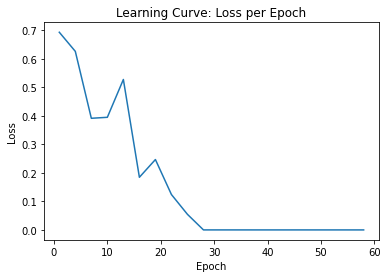

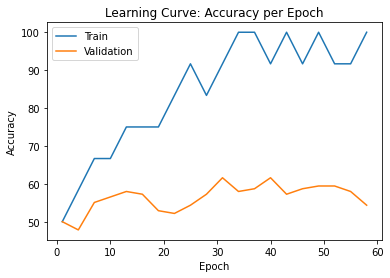

In [ ]:
plot_single_learning_curve(*learning_curve_infos)

In [ ]:
print("Start CNN sanity")
model = CNN(n=8)
model.to(device)

title=""
learning_curve_infos=train(model,train_data=train_data[:2,...], 
          validation_data=valid_data[:2,...], 
          batch_size=6,
          learning_rate=0.001, 
          weight_decay=0,
          epochs=60)

Start CNN sanity
Epoch 1.[Val Acc 50%] [Val pos Acc 0%] [Val neg Acc 100%]\ [Train Acc 50% Train pos Acc 0%,Train neg Acc 100%, loss 0.708872]
Epoch 4.[Val Acc 51%] [Val pos Acc 99%] [Val neg Acc 3%]\ [Train Acc 50% Train pos Acc 100%,Train neg Acc 0%, loss 0.692456]
Epoch 7.[Val Acc 54%] [Val pos Acc 42%] [Val neg Acc 65%]\ [Train Acc 50% Train pos Acc 83%,Train neg Acc 17%, loss 0.692318]
Epoch 10.[Val Acc 47%] [Val pos Acc 61%] [Val neg Acc 33%]\ [Train Acc 42% Train pos Acc 83%,Train neg Acc 0%, loss 0.672736]
Epoch 13.[Val Acc 51%] [Val pos Acc 83%] [Val neg Acc 19%]\ [Train Acc 50% Train pos Acc 83%,Train neg Acc 17%, loss 0.694883]
Epoch 16.[Val Acc 49%] [Val pos Acc 51%] [Val neg Acc 46%]\ [Train Acc 42% Train pos Acc 83%,Train neg Acc 0%, loss 0.691707]
Epoch 19.[Val Acc 50%] [Val pos Acc 29%] [Val neg Acc 71%]\ [Train Acc 50% Train pos Acc 67%,Train neg Acc 33%, loss 0.668997]
Epoch 22.[Val Acc 50%] [Val pos Acc 49%] [Val neg Acc 51%]\ [Train Acc 58% Train pos Acc 83%,Train n

Note that for both networks we arrived to more than 90% training accuracy in some epochs.

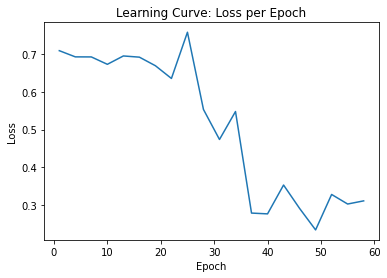

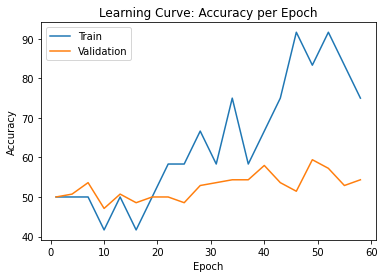

In [ ]:
plot_single_learning_curve(*learning_curve_infos)

### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**
The criteria for choosing the best model is the validation accuracy which is usually used for hyper-parameters tuning. If during training, the model achieved the best validation accuracy in two or more different epochs, we chose the model in which $|\text{Validation positive acc}-\text{Validation negative acc}|$ is minimal, which means that the negative and positive acc values are closer, thus the predicitions are more balanced.

As there is a lot combinations of hyper-parameters values, we used (as suggested) a kind of greedy method that first tries to find the best learning rate where all the other values are fixed to some reasonable values, and then optimizing the mini-batch size where the learning rate is the learning rate which led to the best validation accuracy, and so on.

As for the learning rate, for both networks, we fixed the batch size to be 10, the kernel size is 5 and $n=4$.
For each network we evaluated each model with $lr=[0.0001, 0.0005, 0.001, 0.005,0.01]$.

In [ ]:
def run_learning_rate_sweep(model_name, train_data,validation_data, device, weight_decay=0):
  models = {"CNN": CNN, "CNNChannel": CNNChannel}
  learning_curve_infos=[]
  lrs=[0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01]
  for lr in lrs:
    print("learning rate",lr)
    model = models[model_name]().to(device)
    curve_info = train(model,train_data=train_data, 
          validation_data=valid_data, 
          batch_size=10,
          learning_rate=lr, 
          eval_freq = 5,
          weight_decay = weight_decay,
          epochs=50)
    learning_curve_infos.append(curve_info)
    print(50*"=")
  
  plot_learning_curve(learning_curve_infos=learning_curve_infos,parameters=lrs, parameter_name="learning rate ", rows = 3, cols=2)


learning rate 1e-05
Epoch 1.[Val Acc 49%] [Val pos Acc 87%] [Val neg Acc 12%]\ [Train Acc 52% Train pos Acc 93%,Train neg Acc 10%, loss 0.693355]
Epoch 6.[Val Acc 52%] [Val pos Acc 51%] [Val neg Acc 54%]\ [Train Acc 49% Train pos Acc 47%,Train neg Acc 51%, loss 0.692851]
Epoch 11.[Val Acc 51%] [Val pos Acc 74%] [Val neg Acc 28%]\ [Train Acc 52% Train pos Acc 68%,Train neg Acc 36%, loss 0.693198]
Epoch 16.[Val Acc 51%] [Val pos Acc 71%] [Val neg Acc 30%]\ [Train Acc 51% Train pos Acc 64%,Train neg Acc 38%, loss 0.694264]
Epoch 21.[Val Acc 50%] [Val pos Acc 58%] [Val neg Acc 42%]\ [Train Acc 52% Train pos Acc 57%,Train neg Acc 47%, loss 0.697006]
Epoch 26.[Val Acc 50%] [Val pos Acc 62%] [Val neg Acc 38%]\ [Train Acc 52% Train pos Acc 67%,Train neg Acc 37%, loss 0.701913]
Epoch 31.[Val Acc 49%] [Val pos Acc 72%] [Val neg Acc 26%]\ [Train Acc 55% Train pos Acc 76%,Train neg Acc 33%, loss 0.674868]
Epoch 36.[Val Acc 53%] [Val pos Acc 71%] [Val neg Acc 35%]\ [Train Acc 56% Train pos Acc 72%,

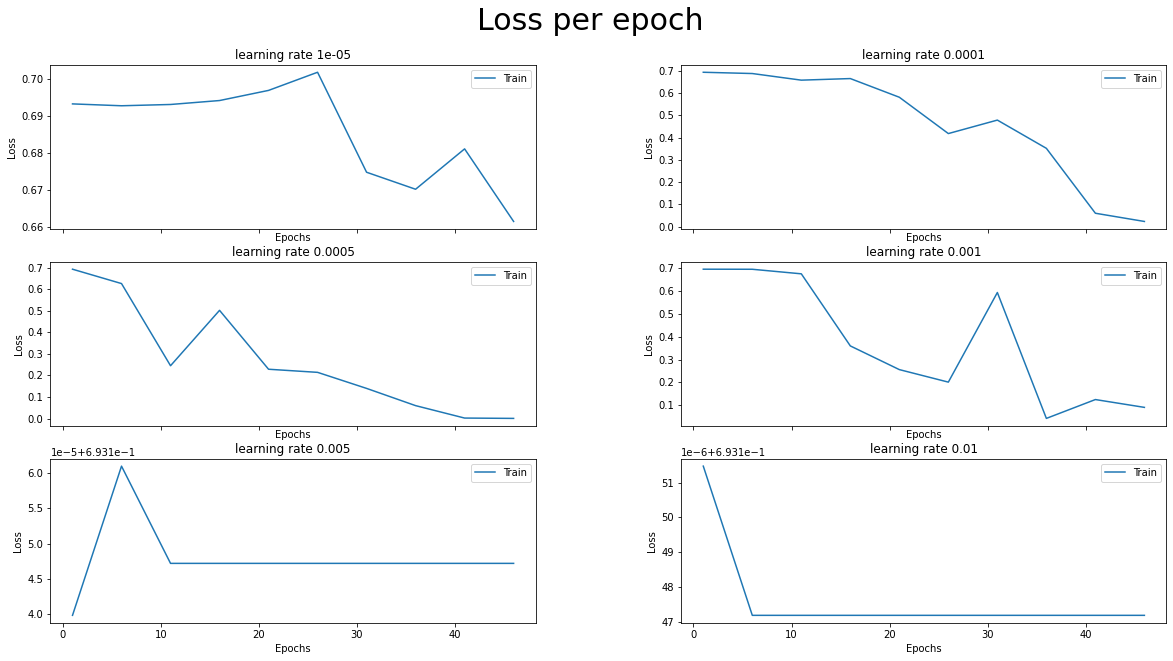

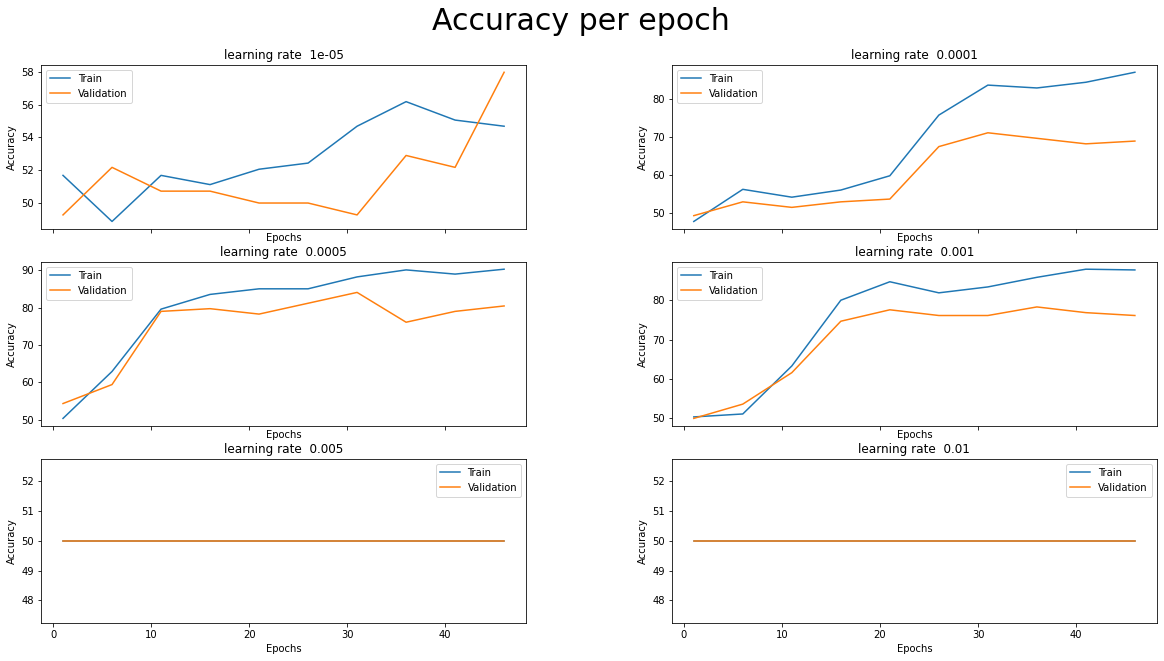

In [ ]:
run_learning_rate_sweep('CNN', train_data, valid_data,device)

learning rate 1e-05
Epoch 1.[Val Acc 50%] [Val pos Acc 100%] [Val neg Acc 0%]\ [Train Acc 50% Train pos Acc 100%,Train neg Acc 0%, loss 0.693418]
Epoch 6.[Val Acc 58%] [Val pos Acc 43%] [Val neg Acc 72%]\ [Train Acc 65% Train pos Acc 54%,Train neg Acc 76%, loss 0.683081]
Epoch 11.[Val Acc 70%] [Val pos Acc 77%] [Val neg Acc 62%]\ [Train Acc 74% Train pos Acc 83%,Train neg Acc 65%, loss 0.696856]
Epoch 16.[Val Acc 78%] [Val pos Acc 80%] [Val neg Acc 75%]\ [Train Acc 77% Train pos Acc 81%,Train neg Acc 72%, loss 0.559959]
Epoch 21.[Val Acc 76%] [Val pos Acc 86%] [Val neg Acc 67%]\ [Train Acc 79% Train pos Acc 84%,Train neg Acc 73%, loss 0.514151]
Epoch 26.[Val Acc 75%] [Val pos Acc 87%] [Val neg Acc 62%]\ [Train Acc 80% Train pos Acc 85%,Train neg Acc 74%, loss 0.467421]
Epoch 31.[Val Acc 78%] [Val pos Acc 87%] [Val neg Acc 70%]\ [Train Acc 81% Train pos Acc 86%,Train neg Acc 77%, loss 0.579134]
Epoch 36.[Val Acc 77%] [Val pos Acc 91%] [Val neg Acc 62%]\ [Train Acc 84% Train pos Acc 90%,

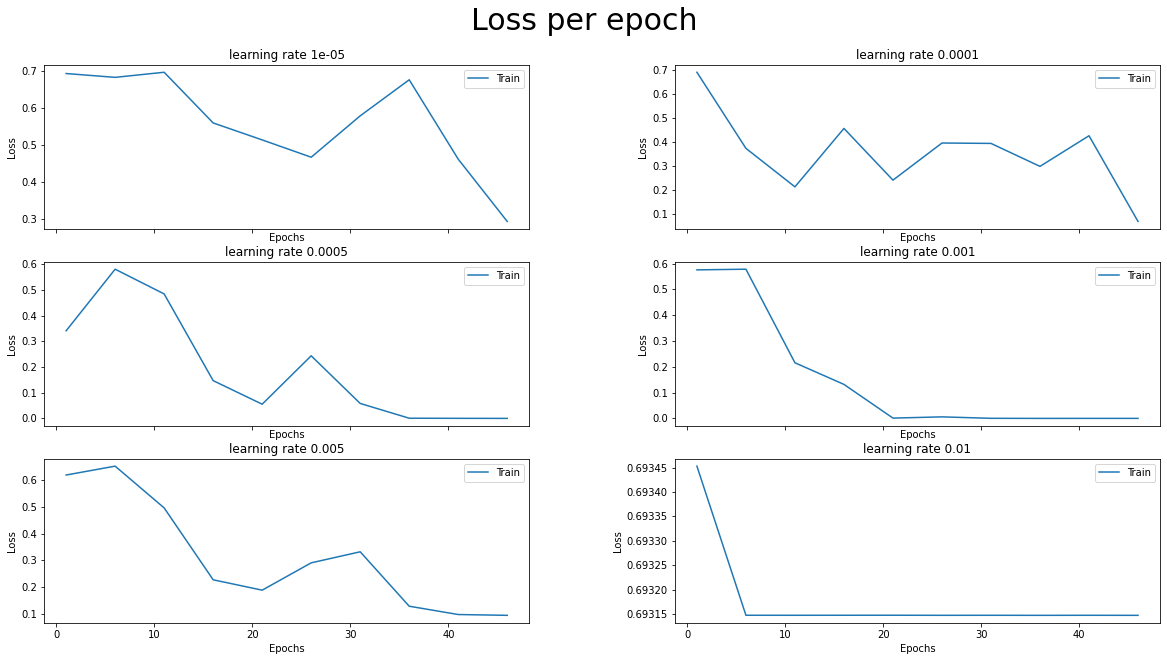

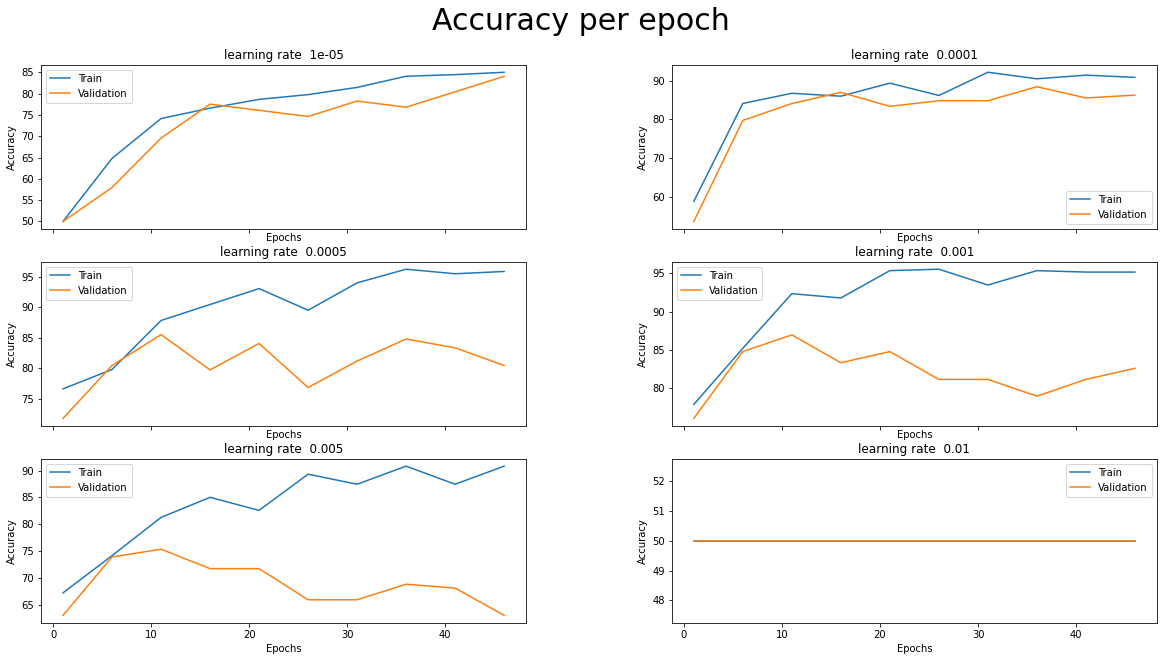

In [ ]:
run_learning_rate_sweep('CNNChannel', train_data, valid_data,device, weight_decay=1e-4)

For the CNN models the best validation accuracy has achieved with $lr=0.0005$.
For the CNNChannel model, the best validation accuracy has achieved with $lr=0.001$, but according to the figures above, it seems that the model encounter an overfit with such learning rate, so we selected $lr=0.0001$.
Now we will select batch size:

In [ ]:
def run_batch_size_sweep(model_name, train_data,validation_data, device, lr, weight_decay=0):
  models = {"CNN": CNN, "CNNChannel": CNNChannel}
  learning_curve_infos=[]
  batch_sizes=[4, 10, 64, 128]
  for bs in batch_sizes:
    print("Batch Size",bs)
    model = models[model_name]().to(device)
    curve_info = train(model,train_data=train_data, 
          validation_data=valid_data, 
          batch_size=bs,
          learning_rate=lr, 
          weight_decay=weight_decay,
          epochs=50)
    learning_curve_infos.append(curve_info)
    print(50*"=")
  
  plot_learning_curve(learning_curve_infos=learning_curve_infos,parameters=batch_sizes, parameter_name="batch size ", rows = 2, cols=2)

Batch Size 4
Epoch 1.[Val Acc 50%] [Val pos Acc 90%] [Val neg Acc 10%]\ [Train Acc 50% Train pos Acc 93%,Train neg Acc 8%, loss 0.692786]
Epoch 4.[Val Acc 79%] [Val pos Acc 87%] [Val neg Acc 71%]\ [Train Acc 79% Train pos Acc 87%,Train neg Acc 72%, loss 0.427984]
Epoch 7.[Val Acc 79%] [Val pos Acc 97%] [Val neg Acc 61%]\ [Train Acc 82% Train pos Acc 98%,Train neg Acc 66%, loss 0.042637]
Epoch 10.[Val Acc 79%] [Val pos Acc 83%] [Val neg Acc 75%]\ [Train Acc 80% Train pos Acc 88%,Train neg Acc 73%, loss 1.201548]
Epoch 13.[Val Acc 77%] [Val pos Acc 93%] [Val neg Acc 61%]\ [Train Acc 82% Train pos Acc 96%,Train neg Acc 69%, loss 0.179456]
Epoch 16.[Val Acc 78%] [Val pos Acc 94%] [Val neg Acc 61%]\ [Train Acc 87% Train pos Acc 98%,Train neg Acc 76%, loss 0.921545]
Epoch 19.[Val Acc 75%] [Val pos Acc 91%] [Val neg Acc 59%]\ [Train Acc 79% Train pos Acc 90%,Train neg Acc 69%, loss 0.493544]
Epoch 22.[Val Acc 78%] [Val pos Acc 84%] [Val neg Acc 71%]\ [Train Acc 88% Train pos Acc 90%,Train neg

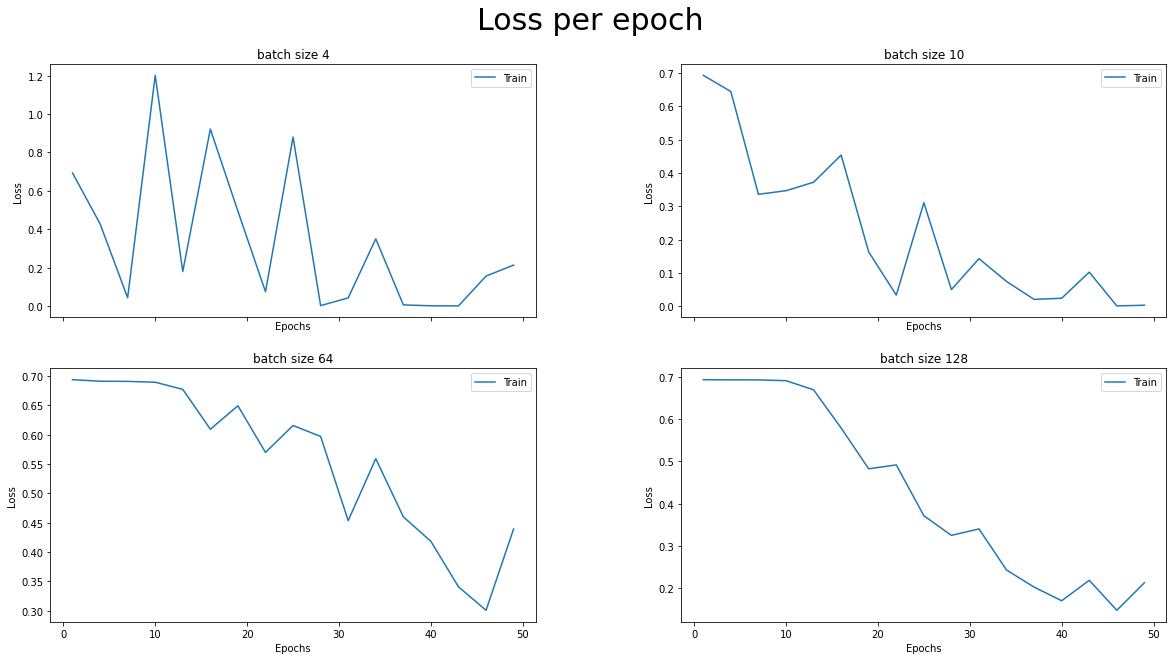

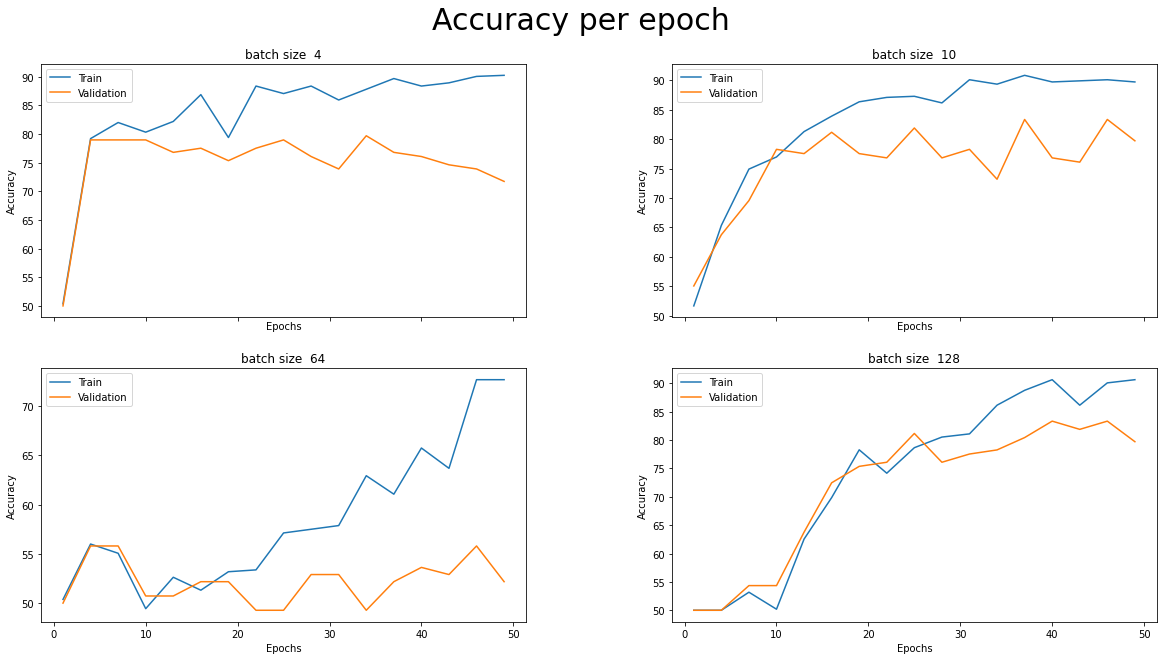

In [ ]:
run_batch_size_sweep('CNN', train_data, valid_data, device, 0.0005)

Batch Size 4
Epoch 1.[Val Acc 72%] [Val pos Acc 96%] [Val neg Acc 48%]\ [Train Acc 74% Train pos Acc 92%,Train neg Acc 56%, loss 0.492676]
Epoch 4.[Val Acc 84%] [Val pos Acc 94%] [Val neg Acc 74%]\ [Train Acc 86% Train pos Acc 90%,Train neg Acc 81%, loss 0.460051]
Epoch 7.[Val Acc 84%] [Val pos Acc 96%] [Val neg Acc 72%]\ [Train Acc 85% Train pos Acc 90%,Train neg Acc 81%, loss 0.259512]
Epoch 10.[Val Acc 88%] [Val pos Acc 93%] [Val neg Acc 83%]\ [Train Acc 87% Train pos Acc 89%,Train neg Acc 86%, loss 0.388345]
Epoch 13.[Val Acc 85%] [Val pos Acc 96%] [Val neg Acc 74%]\ [Train Acc 88% Train pos Acc 94%,Train neg Acc 81%, loss 0.223906]
Epoch 16.[Val Acc 88%] [Val pos Acc 96%] [Val neg Acc 80%]\ [Train Acc 90% Train pos Acc 93%,Train neg Acc 86%, loss 0.227434]
Epoch 19.[Val Acc 80%] [Val pos Acc 97%] [Val neg Acc 62%]\ [Train Acc 85% Train pos Acc 98%,Train neg Acc 72%, loss 0.007183]
Epoch 22.[Val Acc 88%] [Val pos Acc 96%] [Val neg Acc 81%]\ [Train Acc 92% Train pos Acc 91%,Train ne

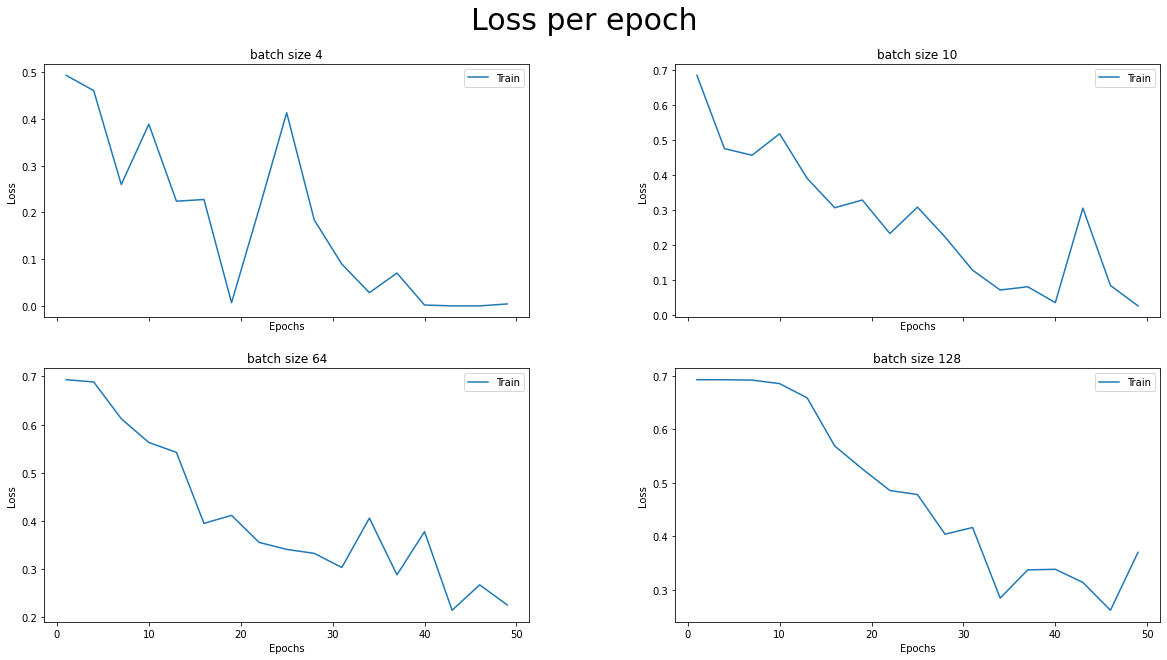

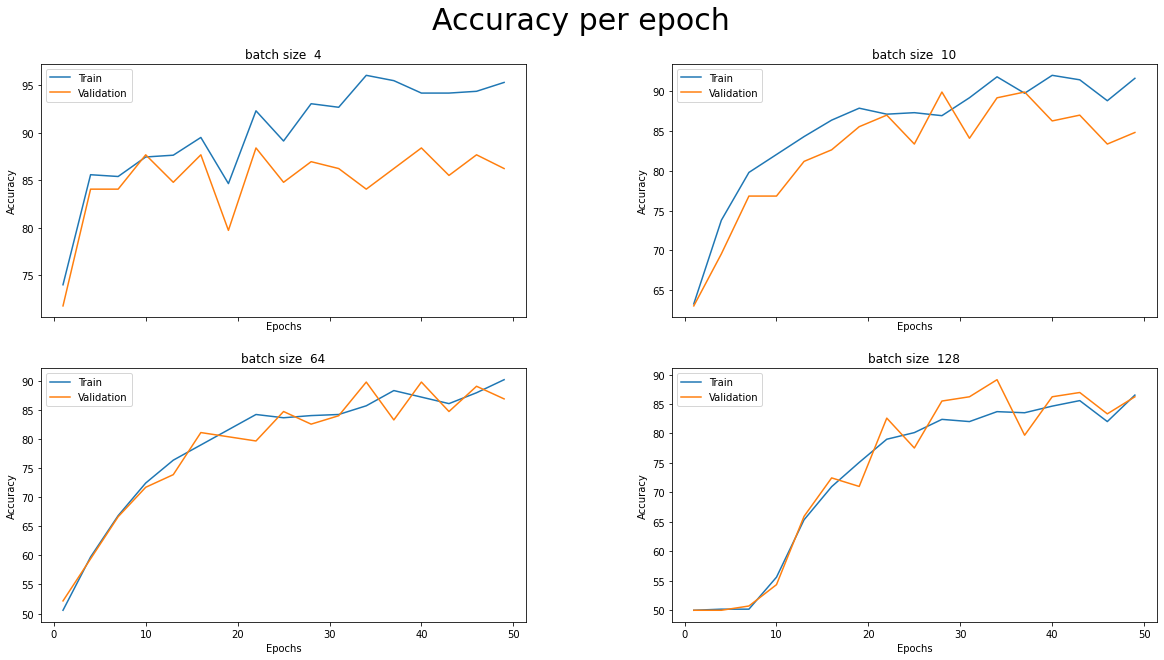

In [ ]:
run_batch_size_sweep('CNNChannel', train_data, valid_data,device, 0.0001, weight_decay=1e-4)

For the CNN and the CNNChannel model the best results are achieved with batch size 10.

In [22]:
def run_n_sweep(model_name, train_data,validation_data, device, lr, bs, weight_decay=0):
  models = {"CNN": CNN, "CNNChannel": CNNChannel}
  learning_curve_infos=[]
  n_sizes=[4, 6, 8, 16]
  for n in n_sizes:
    print("n Size",n)
    model = models[model_name](n=n).to(device)
    curve_info = train(model,train_data=train_data, 
          validation_data=valid_data, 
          batch_size=bs,
          learning_rate=lr, 
          weight_decay=weight_decay,
          epochs=50)
    learning_curve_infos.append(curve_info)
    print(50*"=")
  
  plot_learning_curve(learning_curve_infos=learning_curve_infos,parameters=n_sizes, parameter_name="filters size ", rows = 2, cols=2)

Here we also added weight_decay=1e-4 to the CNN model to reduce overfitting

n Size 4
Epoch 1.[Val Acc 49%] [Val pos Acc 80%] [Val neg Acc 19%]\ [Train Acc 50% Train pos Acc 76%,Train neg Acc 24%, loss 0.693342]
Epoch 4.[Val Acc 54%] [Val pos Acc 88%] [Val neg Acc 19%]\ [Train Acc 55% Train pos Acc 87%,Train neg Acc 23%, loss 0.692594]
Epoch 7.[Val Acc 53%] [Val pos Acc 84%] [Val neg Acc 22%]\ [Train Acc 57% Train pos Acc 81%,Train neg Acc 33%, loss 0.718958]
Epoch 10.[Val Acc 61%] [Val pos Acc 42%] [Val neg Acc 80%]\ [Train Acc 68% Train pos Acc 49%,Train neg Acc 87%, loss 0.512346]
Epoch 13.[Val Acc 71%] [Val pos Acc 80%] [Val neg Acc 62%]\ [Train Acc 79% Train pos Acc 81%,Train neg Acc 78%, loss 0.869349]
Epoch 16.[Val Acc 74%] [Val pos Acc 90%] [Val neg Acc 58%]\ [Train Acc 84% Train pos Acc 96%,Train neg Acc 72%, loss 0.417971]
Epoch 19.[Val Acc 73%] [Val pos Acc 77%] [Val neg Acc 70%]\ [Train Acc 87% Train pos Acc 92%,Train neg Acc 82%, loss 0.136323]
Epoch 22.[Val Acc 73%] [Val pos Acc 72%] [Val neg Acc 74%]\ [Train Acc 90% Train pos Acc 93%,Train neg Ac

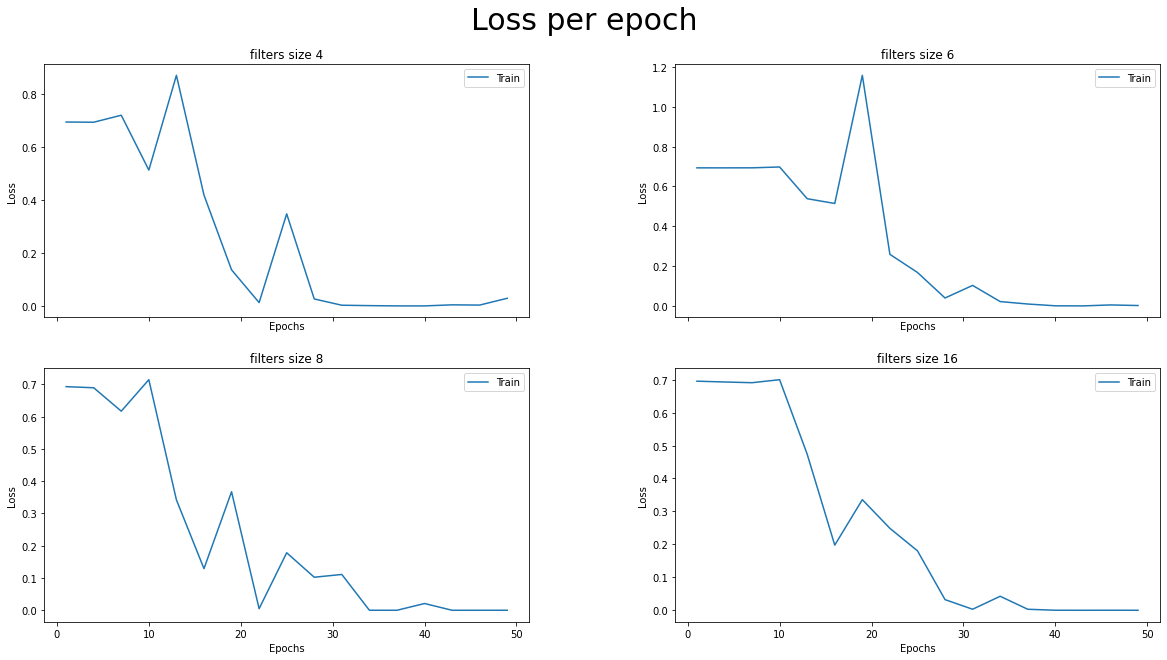

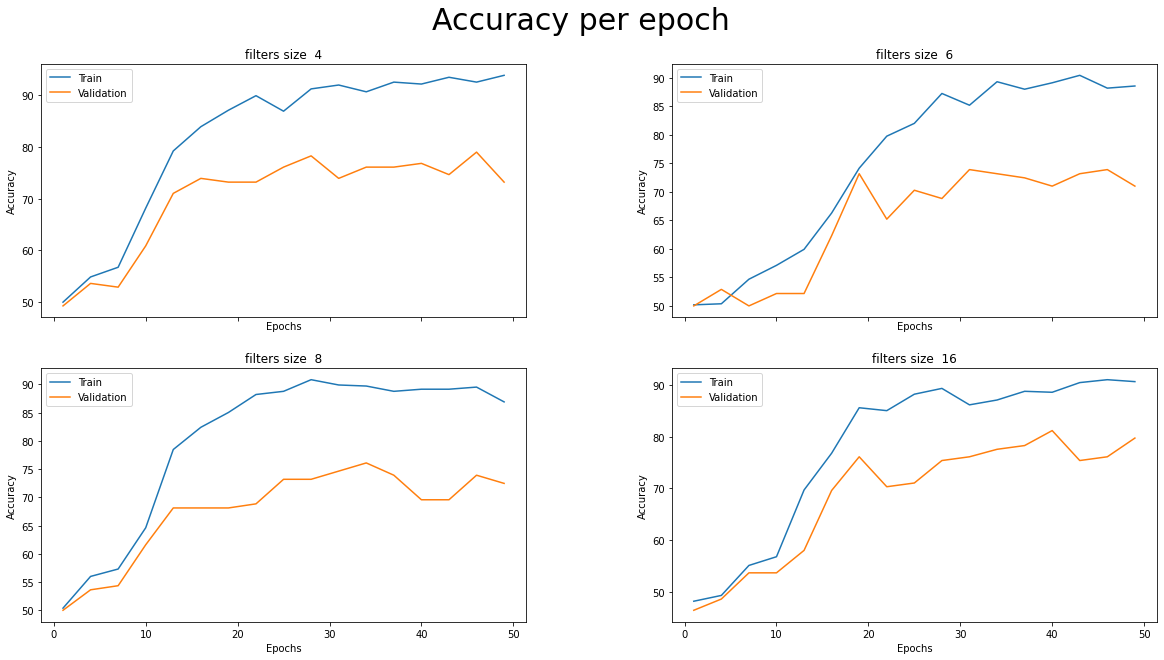

In [23]:
run_n_sweep('CNN', train_data, valid_data, device, 0.0005, 10, weight_decay=1e-4)

n Size 4
Epoch 1.[Val Acc 66%] [Val pos Acc 87%] [Val neg Acc 45%]\ [Train Acc 60% Train pos Acc 80%,Train neg Acc 39%, loss 0.691859]
Epoch 4.[Val Acc 77%] [Val pos Acc 100%] [Val neg Acc 54%]\ [Train Acc 78% Train pos Acc 93%,Train neg Acc 63%, loss 0.459703]
Epoch 7.[Val Acc 86%] [Val pos Acc 87%] [Val neg Acc 84%]\ [Train Acc 87% Train pos Acc 87%,Train neg Acc 87%, loss 0.231638]
Epoch 10.[Val Acc 86%] [Val pos Acc 88%] [Val neg Acc 83%]\ [Train Acc 87% Train pos Acc 85%,Train neg Acc 89%, loss 0.414602]
Epoch 13.[Val Acc 89%] [Val pos Acc 88%] [Val neg Acc 90%]\ [Train Acc 86% Train pos Acc 88%,Train neg Acc 83%, loss 0.171495]
Epoch 16.[Val Acc 86%] [Val pos Acc 93%] [Val neg Acc 80%]\ [Train Acc 87% Train pos Acc 93%,Train neg Acc 80%, loss 0.169942]
Epoch 19.[Val Acc 88%] [Val pos Acc 86%] [Val neg Acc 91%]\ [Train Acc 87% Train pos Acc 84%,Train neg Acc 90%, loss 0.470087]
Epoch 22.[Val Acc 88%] [Val pos Acc 97%] [Val neg Acc 78%]\ [Train Acc 88% Train pos Acc 93%,Train neg A

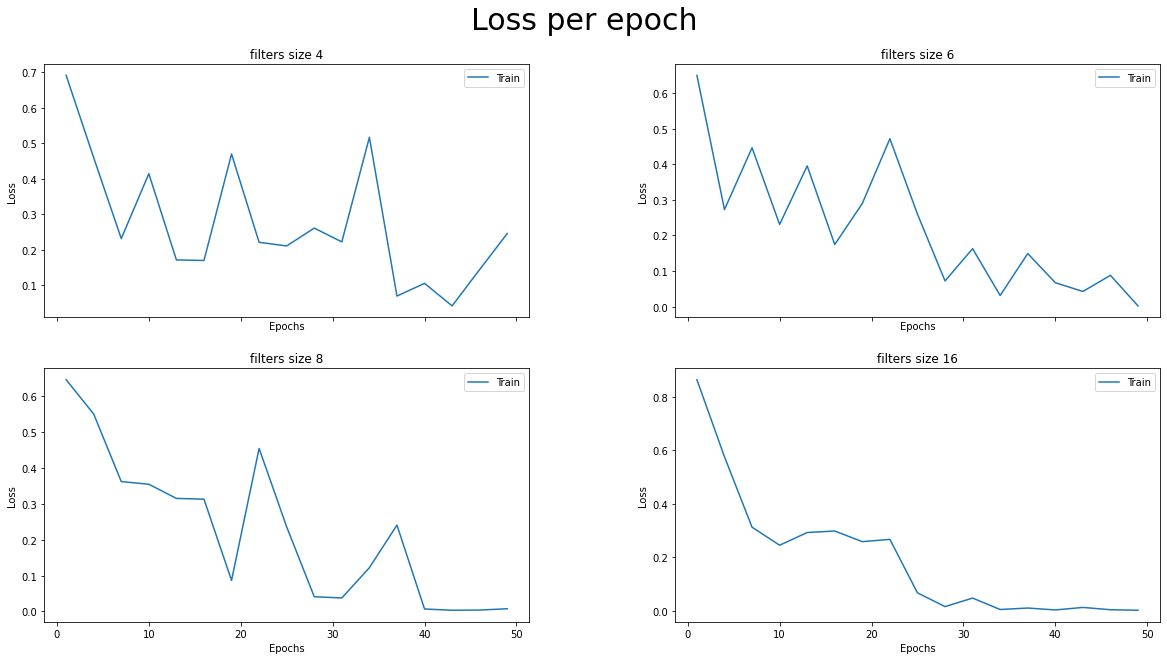

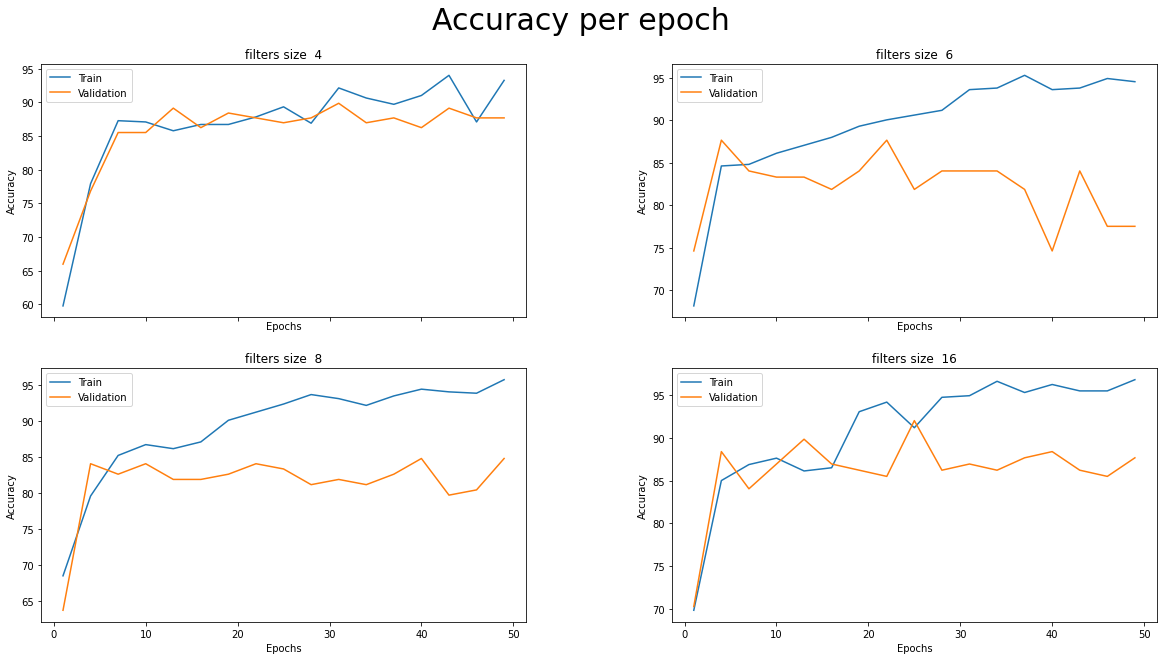

In [22]:
run_n_sweep('CNNChannel', train_data, valid_data, device, 0.0001, 10, weight_decay=1e-4)

For the CNN model the best results aer achieved with $n=16$, but the gap between the validation positive accuracy and the validation negative accuracy is relatively large. Thus, we selected $n=4$. For the CNNChannel the best performance are achieved with $n=16$.

For both models the best result are achieved with kernel size 5.


### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

The best CNNChannel model has achieved with $lr=0.0001$, batch size = 10, n=16, kernel size = 5, and weight_decay=1e-4.

The best CNN model has achieved with $lr=0.0005$, batch size = 10, n=4, kernel size = 5, and weight_decay=1e-4.

Start CNN Best Model training procedure
Epoch 1.[Val Acc 49%] [Val pos Acc 25%] [Val neg Acc 72%]\ [Train Acc 50% Train pos Acc 37%,Train neg Acc 63%, loss 0.693444]
saving best model
Epoch 2.[Val Acc 50%] [Val pos Acc 100%] [Val neg Acc 0%]\ [Train Acc 50% Train pos Acc 100%,Train neg Acc 0%, loss 0.693977]
saving best model
Epoch 3.[Val Acc 50%] [Val pos Acc 100%] [Val neg Acc 0%]\ [Train Acc 50% Train pos Acc 100%,Train neg Acc 0%, loss 0.693184]
Epoch 4.[Val Acc 49%] [Val pos Acc 45%] [Val neg Acc 52%]\ [Train Acc 51% Train pos Acc 52%,Train neg Acc 51%, loss 0.693215]
Epoch 5.[Val Acc 49%] [Val pos Acc 70%] [Val neg Acc 29%]\ [Train Acc 51% Train pos Acc 74%,Train neg Acc 28%, loss 0.692737]
Epoch 6.[Val Acc 51%] [Val pos Acc 100%] [Val neg Acc 1%]\ [Train Acc 52% Train pos Acc 97%,Train neg Acc 7%, loss 0.693865]
saving best model
Epoch 7.[Val Acc 49%] [Val pos Acc 43%] [Val neg Acc 54%]\ [Train Acc 51% Train pos Acc 50%,Train neg Acc 53%, loss 0.707793]
Epoch 8.[Val Acc 49%] [Va

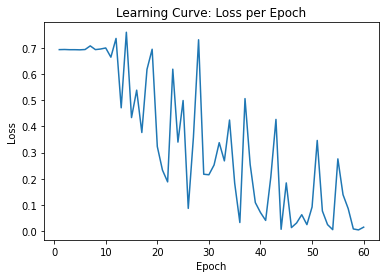

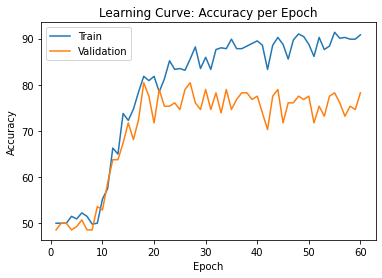

In [24]:
print("Start CNN Best Model training procedure")
model = CNN(n=4)
model.to(device)

title=""
learning_curve_infos=train(model,train_data=train_data, 
          validation_data=valid_data, 
          batch_size=10,
          learning_rate=0.0005, 
          weight_decay=1e-4,
          epochs=60,
          eval_freq=1,
          to_save = True)
plot_single_learning_curve(*learning_curve_infos)

The best validaion accuracy that we have achieved for the CNN model is 80%

Start CNN Channel Best Model training procedure
Epoch 1.[Val Acc 77%] [Val pos Acc 93%] [Val neg Acc 61%]\ [Train Acc 81% Train pos Acc 93%,Train neg Acc 69%, loss 0.436169]
saving best model
Epoch 2.[Val Acc 84%] [Val pos Acc 88%] [Val neg Acc 80%]\ [Train Acc 82% Train pos Acc 85%,Train neg Acc 79%, loss 0.703542]
saving best model
Epoch 3.[Val Acc 86%] [Val pos Acc 96%] [Val neg Acc 75%]\ [Train Acc 81% Train pos Acc 94%,Train neg Acc 68%, loss 0.537053]
saving best model
Epoch 4.[Val Acc 83%] [Val pos Acc 94%] [Val neg Acc 72%]\ [Train Acc 84% Train pos Acc 93%,Train neg Acc 76%, loss 0.416493]
Epoch 5.[Val Acc 82%] [Val pos Acc 83%] [Val neg Acc 81%]\ [Train Acc 83% Train pos Acc 80%,Train neg Acc 86%, loss 0.596248]
Epoch 6.[Val Acc 83%] [Val pos Acc 97%] [Val neg Acc 68%]\ [Train Acc 81% Train pos Acc 97%,Train neg Acc 65%, loss 0.190446]
Epoch 7.[Val Acc 83%] [Val pos Acc 93%] [Val neg Acc 74%]\ [Train Acc 85% Train pos Acc 95%,Train neg Acc 74%, loss 0.262092]
Epoch 8.[Val Acc

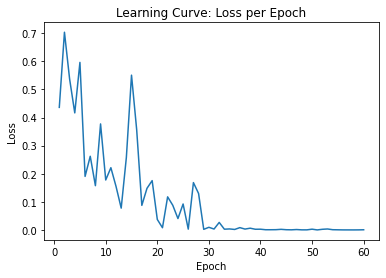

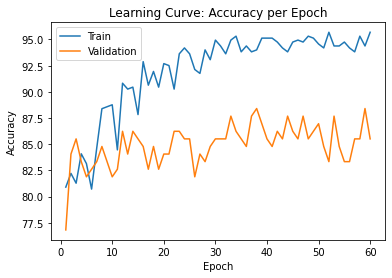

In [40]:
print("Start CNN Channel Best Model training procedure")
model = CNNChannel(n=16)
model.to(device)

title=""
learning_curve_infos=train(model,train_data=train_data, 
          validation_data=valid_data, 
          batch_size=10,
          learning_rate=0.0001, 
          weight_decay=1e-4,
          epochs=60,
          eval_freq=1,
          to_save = True)
plot_single_learning_curve(*learning_curve_infos)

As we thought, the best model is the CNNChannel model.
We used the hyper-parameters that describd in the beggining of this section. The best validation accuracy is 88%

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

The best model is the CNNChannel, with $lr=0.0001$, batch size = 10, n=16, kernel size = 5, and wd=1e-4. In section 3-d, we achieved the maximal validation accuracy of 88%, with Val_pos_Acc=90%, Val_neg_Acc=87%, Train Acc=94%, Train_pos_Acc=100%,and Train_neg_Acc=89%.

In [45]:
#read best model

model = CNNChannel(n=16)
model.load_state_dict(torch.load('/content/gdrive/My Drive/shoes_data_set/checkpoints/ckpt-acc-88.40579710144927.pk'))

<All keys matched successfully>

In [62]:
# Write your code here. Make sure to include the test accuracy in your report

pos_test_acc, neg_test_acc = get_accuracy(model, test_w_data)
print("Women Test set: [Acc (avg %.1f%%), (positives %.1f%%), (negatives: %.1f%%)]" % (
 ((pos_test_acc+neg_test_acc)/2) * 100, pos_test_acc * 100, neg_test_acc * 100))

pos_val_acc, neg_val_acc = get_accuracy(model, test_m_data)
print("Men Test set: [Acc (avg %.1f%%), (positives %.1f%%), (negatives: %.1f%%)]" % (
 ((pos_val_acc+neg_val_acc)/2) * 100, pos_val_acc * 100, neg_val_acc * 100))

Women Test set: [Acc (avg 86.7%), (positives 90.0%), (negatives: 83.3%)]
Men Test set: [Acc (avg 81.7%), (positives 80.0%), (negatives: 83.3%)]


We see that the results for women shoes are better. In addition, in this both test sets the positive an negative accuracy ratio is close.

### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.


In [48]:
def plot_correct_pos(model,data, corr):
  comp = 0
  if corr == 'correct':
    comp = 1
  data_pos = generate_same_pair(data)
  for i in range(0, len(data_pos), 1):
    x = torch.Tensor(data_pos[i:i+1]).transpose(1, 3)
    z = model(x)
    pred = z.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    if pred==comp:
      plt.figure()
      if comp == 1:
        plt.title("Corectly classified as from the same pair")
      else:
        plt.title("Wrongly classified as not from the same pair")
      plt.imshow(data_pos[i]+0.5)
      return

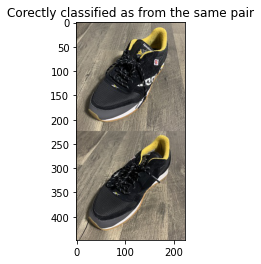

In [49]:
plot_correct_pos(model, test_m_data, 'correct')

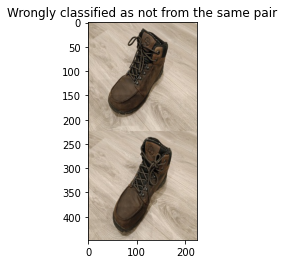

In [50]:
plot_correct_pos(model, test_m_data, 'incorrect')


### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

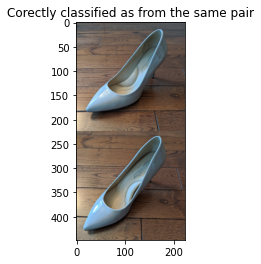

In [51]:
plot_correct_pos(model, test_w_data, 'correct')

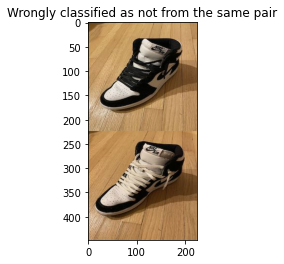

In [52]:
plot_correct_pos(model, test_w_data, 'incorrect')

Here, the model "worngly classified as not from the same pair" but we notes that the shoelaces are different so this shoes are not realy identical.

**Exporting the code to PDF**

In [57]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [58]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [59]:
!cp gdrive/My\ Drive/Colab\ Notebooks/Assignment3_ipynb.ipynb ./
!jupyter nbconvert --to=pdf "Assignment3_ipynb.ipynb"

[NbConvertApp] Converting notebook Assignment3_ipynb.ipynb to pdf
[NbConvertApp] Support files will be in Assignment3_ipynb_files/
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files
[NbConvertApp] Making directory ./Assignment3_ipynb_files